# Проект по А/B-тестированию

Предоставлены данные с результатами A/B-теста: recommender_system_test. 
- Группы: А (контрольная), B (новая платёжная воронка). 
- Дата запуска тестирования: 2020-12-07. 
- Дата остановки набора новых пользователей: 2020-12-21.
- Дата остановки теста: 2021-01-04. 
- Ожидаемое количество участников теста: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
    - конверсии в просмотр карточек товаров — событие `product_page`
    - просмотры корзины — `product_cart`
    - покупки — `purchase`.

Поставленная задача: оценить корректность проведения теста, провести оценку результатов A/B-теста.

<font size=+1><b>Описание данных:</b></font><br>

Календарь маркетинговых событий на 2020 год ab_project_marketing_events.csv:
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

Пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года final_ab_new_users.csv:
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

События новых пользователей в период с 7 декабря 2020 по 4 января 2021 года final_ab_events.csv:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок,
- `purchase` , в этом поле хранится стоимость покупки в долларах.

Таблица участников тестов final_ab_participants.csv:
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

<font size=+1><b>План работы:</b></font><br>
- Загрузить данные и изучить общую информацию.
- Выполнить предобработку данных.
- Оценить корректность проведения теста, проверить:
    - период набора пользователей в тест и его соответствие требованиям технического задания;
    - регион регистрации пользователей, составляет ли общее количество пользователей из целевого региона 15% от общего числа пользователей из целевого региона, зарегистрированных в период набора пользователей в тест;
    - динамику набора пользователей в группы теста, равномерность распределения пользователей по группам теста и корректность их формирования;
    - удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.
- Изучить данные о пользовательской активности:
    - даты совершения событий участниками теста: совпадают ли они с датами проведения теста, согласно техническому заданию;
    - активность пользователей: все ли зарегистрированные пользователи прошли авторизацию и совершали переход по продуктовой воронке;
    - если есть пользователи, которые не совершали событий после регистрации, изучить их количество и распределение между группами теста; 
    - сделать вывод о необходимости учитывать пользователей без событий при изучении результатов теста;
    - рассчитать лайфтайм совершения события пользователем после регистрации, оставить только те события, которые были совершены в первые 14 дней с момента регистрации;
    - представить развернутый вывод о соответствии теста требованиям технического задания и возможности получения достоверных результатов АБ-теста, исходя из базового показателя конверсии в 50%.
- Провести исследовательский анализ данных. Изучить:
    - распределение количества событий на пользователя в разрезе групп теста;
    - динамику количества событий в группах теста по дням;
    - убедиться, что время проведения теста не совпадает с маркетинговыми и другими активностями;
    - построить продуктовую воронку;
    - сделать общий вывод об изменении пользовательской активности в тестовой группе, по сравнению с контрольной.
- Провести оценку результатов A/B-тестирования:
    - проверить статистическую разницу долей z-критерием.
    - сделать вывод о результатах A/B-тестирования
    - обосновать, был ли достигнут ожидаемый эффект в изменении конверсии
- Описать выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. 
- Сделать общее заключение о корректности проведения теста. 
- Дать рекомендации.

## Загрузка данных

### Используемые библиотеки и функции

In [1]:
# Используемые библиотеки
import pandas as pd
import numpy as np
import math as mth
import scipy.stats as st
import matplotlib.pyplot as plt
from plotly import graph_objects as go

In [2]:
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use('fivethirtyeight')
plt.rc('figure', figsize=(20, 8))
# цвет таблиц
cmap_table = 'Blues'

In [3]:
# Функция для загрузки данных
def main_info (dataset):
    data = pd.read_csv(dataset, sep=',')
    pd.set_option('max_colwidth', 200)
    display(data.head())
    print('------------------------------------------')
    display('Основная информация по столбцам таблицы:')
    display(data.info())
    print('-------------------------------------')
    display('Доля пропусков по столбцам таблицы:')
    display(pd.DataFrame(round(data.isna().mean()\
                               .sort_values(ascending=False), 3))\
                        .style.format('{:.1%}')\
                        .background_gradient('coolwarm'))
    print('----------------------------------------')
    display('Количество явных дубликатов в таблице:')
    display(data.duplicated().sum())
    return data

In [4]:
# функция для создания сводной таблицы
def table_pivot(data, col_group, values, func):
    return data.groupby(by=col_group, as_index=False)\
               .agg(total = (values, func))

In [5]:
# функция для создания сводной таблицы по продуктовой ячейке
def event_pivot(data, values, func):
    df = data.groupby(by='event_name')\
             .agg(total = (values, func))\
             .reindex(new_index)
    df['part'] = df['total'] / (df['total'].sum())
    return df

In [6]:
# функция вычисления лайфтайма шагов воронки
def event_step(data):
    df = data.groupby(by='event_name')\
             .agg(total = ('user_id', 'nunique'))\
             .reindex(new_index)\
             .reset_index()
    for i in range(1, len(df)):
        df.loc[i, 'ret_rate'] = (df.loc[i, 'total'] / df.loc[i-1, 'total'])
    return df

In [7]:
# функция пересечения пользователей
def AB_merge (group1, group2):
    return pd.merge(group1, group2, how ='inner', 
                    on ='user_id')['user_id'].nunique()
    

In [8]:
# функция для графиков в разрезе групп
def plot_bar(df, index, values, func):
    return df.pivot_table(index=index, 
                          columns='group', 
                          values=values, 
                          aggfunc=func)\
             .plot(kind='bar')

In [9]:
# функция для проверки гипотез
def test_hipot(n_event):
    result_group_A = result_group.loc[0, 'total']
    result_group_B = result_group.loc[1, 'total']
    # пропорция успехов в группе 1:
    p1 = successes.loc[n_event, 'total_A'] / result_group_A
    # пропорция успехов во группе 2:
    p2 = successes.loc[n_event, 'total_B'] / result_group_B
    # пропорция успехов в комбинированном датасете двух групп:
    p_combined = (successes.loc[n_event, 'total_A'] + successes.loc[n_event, 'total_B'])\
                 / (result_group_A + result_group_B)

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
                                    p_combined * (1 - p_combined) *\
                                    (1/result_group_A + 1/result_group_B)
                                   )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие: ', successes.loc[n_event, 'event_name'])
    print('Доля пользователей, прошедших на этот этап, в группе А: ',
          "{0:.1%}".format(successes.loc[n_event, 'total_A']/result_group_A))
    print('Доля пользователей, прошедших на этот этап, в группе B: ',
          "{0:.1%}".format(successes.loc[n_event, 'total_B']/result_group_B))
    print('p-значение: ', "{0:.3}".format(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        print('')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('')

### Загрузка данных и основная информация

#### Таблица с календарём событий

In [10]:
mark_events = main_info('ab_project_marketing_events.csv')

name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

Была загружена таблица с календарём маркетинговых событий на 2020 год 
- В таблице 14 событий и 4 столбца
- В таблице нет пропусков данных и явных дубликатов
- Столбцы с датами необходимо преобразовать к правильному типу.

#### Таблица с пользователями с 7 по 21 декабря 2020 года

In [11]:
users = main_info('final_ab_new_users.csv')

user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

Была загружена таблица со всеми пользователями, зарегистрированными в интернет-магазине в период с 7 по 21 декабря 2020 года
- В таблице 61733 строчек и 4 столбца
- В таблице нет пропусков данных и явных дубликатов
- Столбец с датой необходимо преобразовать к правильному типу.

#### Таблица с событиями пользователей с 7 декабря 2020 по 4 января 2021 года

In [12]:
events = main_info('final_ab_events.csv')

user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

Была загружена таблица с событиями для пользователей, зарегистрированными в интернет-магазине в период с 7 декабря 2020 по 4 января 2021 года 
- В таблице 440317 строчек и 4 столбца
- В таблице нет явных дубликатов, зато есть 86% пропусков в столбце с деталями
- Столбец с датой необходимо преобразовать к правильному типу.

#### Таблица участников теста

In [13]:
user_group = main_info('final_ab_participants.csv')

user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test

------------------------------------------


'Основная информация по столбцам таблицы:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

-------------------------------------


'Доля пропусков по столбцам таблицы:'

----------------------------------------


'Количество явных дубликатов в таблице:'

0

Была загружена таблица с участниками теста 
- В таблице 18268 строчек и 3 столбца
- В таблице нет явных дубликатов и пропусков в данных.

### Промежуточные выводы:

- Было загружено 4 датасета с информацией о проведённом A/B тесте.
- Ни в одной таблице нет явных дубликатов.
- В таблице с событиями пользователей в 1 столбце есть 86% пропусков данных.
- Пропуски в данных могли возникнуть из-за отсутствия дополнительной информации о событиях.
- Столбцы с датами в каждой таблице необходимо привести к правильному типу данных.

## Подготовка данных

Приведём столбцы с датой к правильному типу данных:

In [14]:
mark_events['start_dt'] = pd.to_datetime(mark_events['start_dt'])
mark_events['finish_dt'] = pd.to_datetime(mark_events['finish_dt'])
users['first_date'] = pd.to_datetime(users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

Проверим уникальность значений в столбцах.

In [15]:
print('Регионы тестирования: ', users['region'].sort_values().unique())
print('Устройства пользователей: ', users['device'].sort_values().unique())
print('Названия событий: ', events['event_name'].sort_values().unique())
print('Названия тестов: ', user_group['ab_test'].sort_values().unique())

Регионы тестирования:  ['APAC' 'CIS' 'EU' 'N.America']
Устройства пользователей:  ['Android' 'Mac' 'PC' 'iPhone']
Названия событий:  ['login' 'product_cart' 'product_page' 'purchase']
Названия тестов:  ['interface_eu_test' 'recommender_system_test']


В тестировании участвовали 4 региона, 4 устройства, было 4 события из воронки для пользователей и 2 названия теста. Для анализа интересен только один тест - под названием recommender_system_test, так как интересно было провести тестирование изменений, связанных с внедрением улучшенной рекомендательной системы.

Проверим, для каких событий присутствовали пропуски в столбце с деталями.

In [16]:
table_pivot(events, 'event_name', 'details', 'count')

event_name  total
0         login      0
1  product_cart      0
2  product_page      0
3      purchase  62740

В таблице детали присутствуют только для события оплаты заказа (вероятно, с ценой заказа). Для других событий нет значений. Таким образом, данные пропуски можно отставить, они никак не искажают данные.

### Промежуточный вывод:

- Столбцы с датами были приведены к правильному типу данных.
- Неявных дубликатов обнаружено не было.
- В тестировании участвовало 2 разных тестов, необходимо оставить нужный.
- Значения в столбце с деталями событий были только для события оплаты заказа.
- Было решено оставить пропуски без заполнения, так как они не появились в столбце случайно и не искажают данные.

## Оценка корректности теста

### Период теста

Проверим даты набора пользователей в тестовые группы для пользователей, участвующих в recommender_system_test и из целевого региона - Европы.

In [17]:
test_user = user_group.query('ab_test == "recommender_system_test"')['user_id'].to_list()

In [18]:
print('Начальная дата набора пользователей в тест: ',
      users.query('user_id in @test_user & region == "EU"')['first_date'].min())
print('Финальная дата набора пользователей в тест: ',
      users.query('user_id in @test_user & region == "EU"')['first_date'].max())
print('Промежуток тестирования: ',
      users.query('user_id in @test_user & region == "EU"')['first_date'].max() - \
      users.query('user_id in @test_user & region == "EU"')['first_date'].min())

Начальная дата набора пользователей в тест:  2020-12-07 00:00:00
Финальная дата набора пользователей в тест:  2020-12-21 00:00:00
Промежуток тестирования:  14 days 00:00:00


Период набора пользователей согласуется с заявленными в ТЗ датах. По ТЗ пользователей набирали, которые были зарегистрированы с 7 декабря по 21 декабря.

### Регион регистрации

Проверим регион регистрации пользователей. Все ли попавшие в тест пользователи представляют целевой регион EU, и составляет ли количество пользователей из EU 15% от общего числа пользователей из целевого региона, зарегистрированных в период набора пользователей в тест.

In [19]:
min_date = users.query('user_id in @test_user')['first_date'].min()
max_date = users.query('user_id in @test_user')['first_date'].max()
print('Регионы пользователей теста: ', users.query('user_id in @test_user')['region'].unique())
print('Доля пользователей из целевого региона: ',
      '{0:.1%}'.format(users.query('user_id in @test_user & region == "EU"')['user_id'].count() /\
                       users.query('region == "EU" & first_date >= @min_date & first_date <= @max_date')
                            ['user_id'].count()))

Регионы пользователей теста:  ['EU' 'APAC' 'CIS' 'N.America']
Доля пользователей из целевого региона:  15.0%


Пользователи, которые участвуют в нашем тестировании, представляют не только целевой регион, и нам нужно будет оставить только целевой - Европу. Но при этом пользователи, участники теста, составляют 15% от общего числа пользователей из Европы, зарегистрированных в период набора пользователей в тест. Так что это условие соблюдается. Оставим в тестовых группах только пользователей из Европы.

In [20]:
test_user = users.query('region == "EU"')['user_id'].to_list()
test_user_eu = user_group.query('user_id in @test_user')['user_id'].to_list()
user_group = user_group.query('user_id in @test_user_eu').reset_index(drop=True)

### Пользователи по группам

Посмотрим на распределение пользователей по группам:

In [21]:
table_pivot(user_group, ['ab_test', 'group'], 'user_id', 'nunique')

ab_test group  total
0        interface_eu_test     A   5831
1        interface_eu_test     B   5736
2  recommender_system_test     A   3634
3  recommender_system_test     B   2717

В группе А необходимого нам теста recommender_system_test пользователей почти на 1000 больше, чем в группе В. Это нужно будет иметь ввиду.

Проверим динамику набора пользователей в тестовые группы.

In [22]:
test_user_A = user_group.query('ab_test == "recommender_system_test" & group == "A"')\
                        ['user_id'].to_list()
test_user_B = user_group.query('ab_test == "recommender_system_test" & group == "B"')\
                        ['user_id'].to_list()

In [23]:
date_A = table_pivot(users.query('user_id in @test_user_A'), 'first_date', 'user_id', 'nunique')
date_B = table_pivot(users.query('user_id in @test_user_B'), 'first_date', 'user_id', 'nunique')
date_AB = date_A.merge(date_B, left_on='first_date', right_on='first_date', how='left')
date_AB['A_share'] = (date_AB['total_x'] / (date_AB['total_x'] + date_AB['total_y']))
date_AB['B_share'] = (date_AB['total_y'] / (date_AB['total_x'] + date_AB['total_y']))
date_AB['B_to_A_group'] = (1 - date_AB['B_share'] / date_AB['A_share'])
date_AB = date_AB.rename(columns={'total_x':'A', 'total_y':'B'})
date_AB.style.format({'A_share':'{:.1%}', 'B_share':'{:.1%}', 'B_to_A_group':'{:.1%}'})

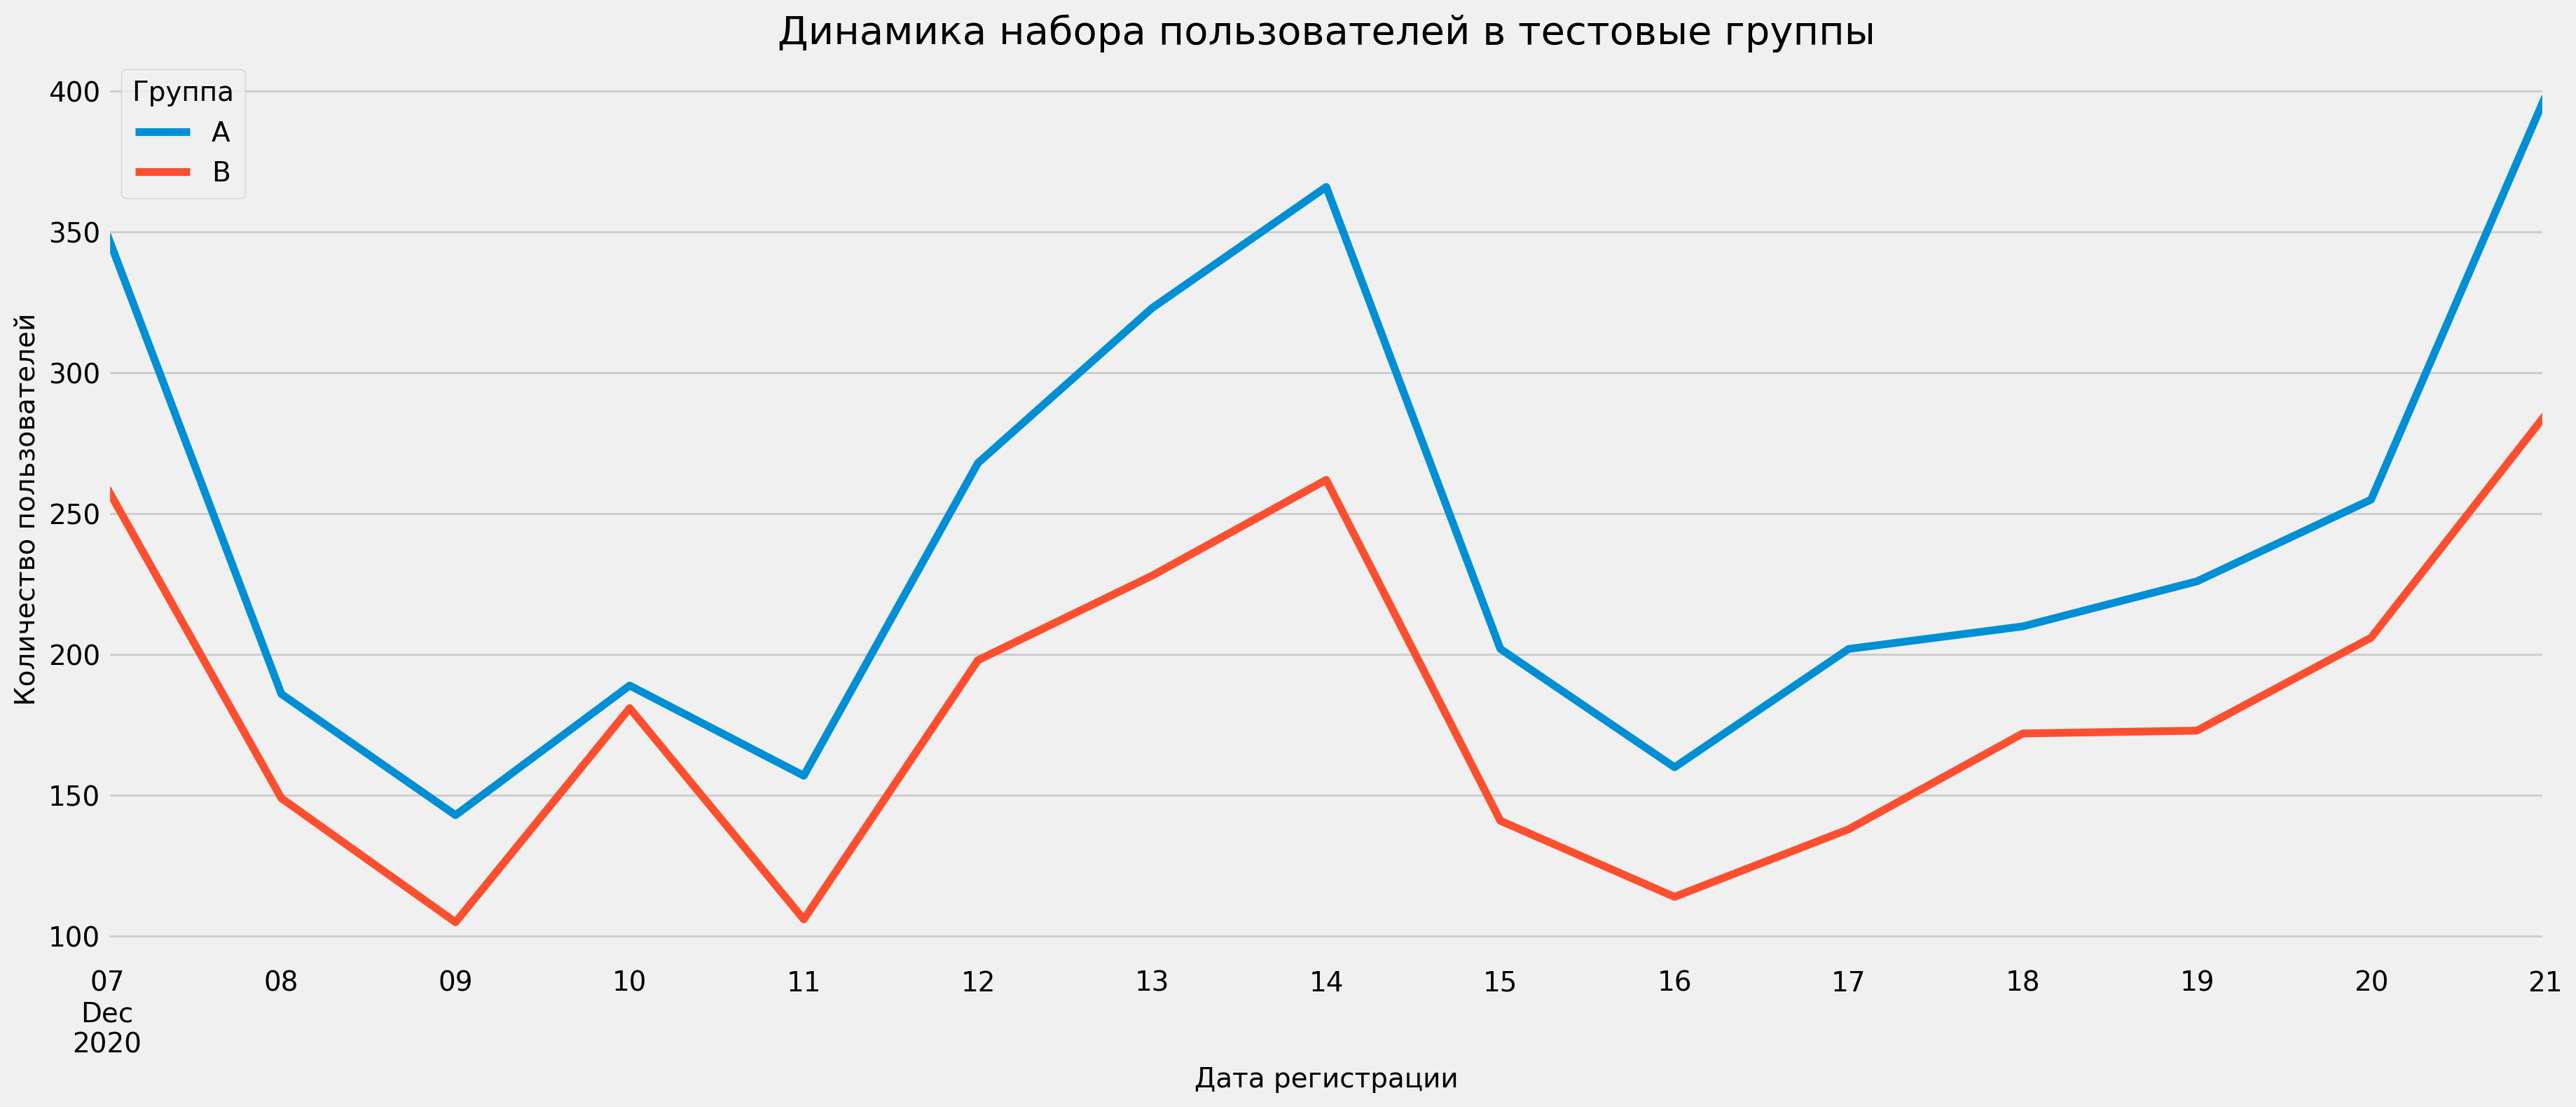

In [24]:
date_AB.plot(x='first_date', y=['A', 'B'])
plt.legend(title='Группа')
plt.xlabel('Дата регистрации')
plt.ylabel('Количество пользователей')
plt.title('Динамика набора пользователей в тестовые группы')
plt.show();

Во все дни в группы А и В попадало разное количество пользователей, причём в группу А больше. Самое большое различие по процентному соотношению между группами приходится на 16 декабря и составляет 32%, самое маленькое - на 10 декабря и составляет 3.5%. Также можно отметить, что тест длился 2 недели, и каждую неделю сначала был спад набора пользователей, а с середины недели - повышение до значений выше, чем в начале недели. То, что пользователей в группе А всегда было больше, чем в группе В необходимо будет учесть в дальнейшем анализе теста.

### Пользователи в двух тестах одновременно

Проверим, есть ли пользователи, которые попали в обе тестовые группы одновременно.

In [25]:
print('Общее количество пользователей: ', user_group.shape[0])
print('Количество уникальных пользователей: ', user_group['user_id'].nunique())

Общее количество пользователей:  17918
Количество уникальных пользователей:  16316


Размерность таблицы и количество уникальных пользователей в таблице с группами не совпадает, уникальных пользователей меньше. Это может означать, что какие-то пользователи попали в обе группы одновременно. Проверим совпадение пользователей в конкурирующих тестах:

In [26]:
test_merge = pd.merge(user_group.query('ab_test == "interface_eu_test"'), 
                      user_group.query('ab_test == "recommender_system_test"'), 
                      how ='inner', 
                      on ='user_id')['user_id']
print('Количество пользователей, находящихся одновременно в двух группах: ', test_merge.nunique())
print('Процент пересекающихся пользователей в двух группах: ',
      '{0:.1%}'.format(test_merge.nunique() / user_group['user_id'].nunique()))

Количество пользователей, находящихся одновременно в двух группах:  1602
Процент пересекающихся пользователей в двух группах:  9.8%


Как видно, 1602 пользователей находятся одновременно в конкурирующих тестах и это составляет почти 10% от всех данных.

In [27]:
AB = AB_merge(user_group.query('ab_test == "recommender_system_test" & group == "A"'), 
              user_group.query('ab_test == "recommender_system_test" & group == "B"'))
print('Количество пользователей, находящихся одновременно в группе А и В: ', AB)
print('Процент пересекающихся пользователей в группе А и В: ',
      '{0:.1%}'.format(AB / user_group['user_id'].nunique()))

Количество пользователей, находящихся одновременно в группе А и В:  0
Процент пересекающихся пользователей в группе А и В:  0.0%


In [28]:
AB = AB_merge(user_group.query('ab_test == "interface_eu_test" & group == "A"'), 
              user_group.query('ab_test == "interface_eu_test" & group == "B"'))
print('Количество пользователей, находящихся одновременно в группе А и В: ', AB)
print('Процент пересекающихся пользователей в группе А и В: ',
      '{0:.1%}'.format(AB / user_group['user_id'].nunique()))

Количество пользователей, находящихся одновременно в группе А и В:  0
Процент пересекающихся пользователей в группе А и В:  0.0%


Но при этом, в каждом тесте отдельно нет пересечений пользователей по группе А и В. Нам необходимо посмотреть на конкретное тестирование (recommender_system_test), поэтому пользователи, которые участвовали сразу в двух тестах будут несколько искажать результаты. Проверим, как распределялись такие пользователи по группам А и В нужного там теста.

In [29]:
user_merg = pd.merge(table_pivot(user_group.query('ab_test == "recommender_system_test"'), 
                                 'group', 'user_id', 'nunique'), 
                     table_pivot(user_group.query('ab_test == "recommender_system_test" & user_id in @test_merge'), 
                                 'group', 'user_id', 'nunique'), 
                     how ='inner', 
                     on ='group')
user_merg = user_merg.rename(columns={'total_x': 'total', 'total_y':'merge'})
user_merg['part'] = user_merg['merge'] / user_merg['total']
user_merg.style.format({'part': '{:.1%}'})

Можно видеть, что пересекающиеся пользователи по тестам, в группы А и В исследуемого теста попали равномерно: по 25% от общего количества пользователей в группах. Поэтому таких пользователей, которые входят в две группы одновременно, можно оставить, так как итоговый результат - отношение конверсии в тестовой группе В к группе А не изменится, так как влияние первого теста на исследуемый был одинаков по группам. Также оставим во всех данных только нужный нам тест recommender_system_test.

In [30]:
user_group = user_group.query('ab_test == "recommender_system_test"').reset_index(drop=True)
test_user_eu = user_group['user_id'].to_list()
users = users.query('user_id in @test_user_eu').reset_index(drop=True)
events = events.query('user_id in @test_user_eu').reset_index(drop=True)

### Пользовательская активность

Посмотрим на даты совершения событий участниками теста.

In [31]:
print('Дата совершения первого события: ', events['event_dt'].min())
print('Дата совершения последнего события: ', events['event_dt'].max())

Дата совершения первого события:  2020-12-07 00:05:57
Дата совершения последнего события:  2020-12-30 12:42:57


События для пользователей, которые участвуют в тестировании, предоставлены с 7 декабря по 30 декабря, и сопадают с датами проведения теста. По ТЗ были заявлены сроки сбора событий с 7 декабря по 4 января.

### Воронка событий

Посмотрим, какие события есть и на их количество:

In [32]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Уникальных событий всего 4 штуки. По логике событий они распологаются в таком порядке:
- `login` - авторизация в приложении
- `product_page` - страница продукта
- `product_cart` - корзина
- `purchase` - покупка продукта

Проверим, были ли среди пользователей, зарегистрированных в тест и из нужной целевой области, которые после регистрации не совершали ни одного события.

In [33]:
test1 = events['user_id'].to_list()
print('Количество пользователей, не совершивших ни одного события после регистрации: ',
      user_group.query('user_id not in @test1')['user_id'].nunique())
print('Процент пользователей, не совершивших ни одного события после регистрации: ',
      '{0:.1%}'.format(user_group.query('user_id not in @test1')['user_id'].nunique() / \
      user_group['user_id'].nunique()))

Количество пользователей, не совершивших ни одного события после регистрации:  2870
Процент пользователей, не совершивших ни одного события после регистрации:  45.2%


Среди зарегистрированных пользователей в тестовый период есть 2870 пользователей, которые после регистрации не совершали никаких событий, и их количество составило 45% от общего количества пользователей, участвующих в тестировании. При анализе показателей теста таких пользователей можно не учитывать, так как интересны только те, кто совершал переходы по продуктовой воронке.

Посмотрим, есть ли пользователи, которые пропустили действие с авторизацией.

In [34]:
print('Количество пользователей теста, совершавших события: ', events['user_id'].nunique())
print('Количество пользователей теста, прошедших авторизацию: ',
      table_pivot(events, 'event_name', 'user_id', 'nunique').loc[0, 'total'])

Количество пользователей теста, совершавших события:  3481
Количество пользователей теста, прошедших авторизацию:  3481


Все пользователи, которые совершали события после регистрации прошли этап с авторизацией.

Посмотрим на частоту событий:

In [35]:
df = table_pivot(events, 'event_name', 'event_name', 'count')
df['part'] = df['total'] / (df['total'].sum())
df.sort_values(by=('total'), ascending=False).style.format({'part': '{:.1%}'})\
  .background_gradient(cmap_table)

Большая часть событий приходится на авторизацию пользователя, а на оплату покупки и просмотра корзины приходится по 13%. Причём, по логике совершения событий просмотр корзины должен происходит до совершения оплаты. Видимо, можно было совершить быструю покупку, минуя этап с корзиной. Необходимо будет это учесть.

Посчитаем, сколько пользователей из тестовых групп совершали то или иное событие:

In [36]:
df = table_pivot(events, 'event_name', 'user_id', 'nunique')
df['part'] = df['total'] / (events['user_id'].nunique())
df.sort_values(by='total', ascending=False).style.format({'part': '{:.1%}'})\
  .background_gradient(cmap_table)

Все зарегистрированные пользователи нужного нам теста из Европы после даты регистрации проходили первый пункт воронки - авторизацию, а на следующий пункт - просмотр страницы товаров переходило 63% пользователей. При этом, разница в процентных пунктах между событиями "корзина" и "оплата" стала больше, чем для частоты событий.

### Горизонт анализа

Необходимо оставить только такие события, которые произошли в течении 14 дней после регистрации пользователя.

In [37]:
lifetime = 14
life_events = pd.merge(events, users[['user_id', 'first_date']], how ='inner', on ='user_id')
life_events['diff'] = (life_events['event_dt'] - life_events['first_date'])
life_events = life_events.query('diff.dt.days <= @lifetime').reset_index(drop=True)

Посмотрим, когда пользователи совершают свои первые события каждого вида после регистрации.

In [38]:
df = life_events.groupby(by=['user_id', 'event_name'], as_index=False)\
                .agg(first_event = ('diff', 'first'))
df['first_event_hour'] = (df['first_event'].dt.total_seconds()/3600).round(2)
df['first_event_minutes'] = (df['first_event'].dt.total_seconds()/60).round(2)
df.groupby(by=['event_name'], as_index=False)\
  .agg(first_event_hour = ('first_event_hour', 'median'),
       first_event_minutes = ('first_event_minutes', 'median'))\
  .style.format({'first_event_hour': '{:.1f}', 'first_event_minutes': '{:.1f}'})\
  .background_gradient(cmap_table)

Все события пользователи совершают в первый день регистрации, причём, в первые 12 часов после регистрации. Можно отметить, что медианное значение событий в минутах идёт немного не последовательно: так, авторизация происходила позже, чем просмотр товаров. Это объясняется тем, что почти половина пользователей дальше авторизации по шагам по продуктовой воронке не сдвинулась. Что увеличило медианное время от момента регистрации.

### Последняя проверка

Посмотрим ещё раз на воронку событий после очистки данных:

In [39]:
df = table_pivot(life_events, 'event_name', 'event_name', 'count')
df['part_event'] = df['total'] / (df['total'].sum())
df.sort_values(by='total', ascending=False).style.format({'part_event': '{:.1%}'})\
  .background_gradient(cmap_table)

In [40]:
df = table_pivot(life_events, 'event_name', 'user_id', 'nunique')
df['part_user'] = df['total'] / (events['user_id'].nunique())
df.sort_values(by='total', ascending=False).style.format({'part_user': '{:.2%}'})\
  .background_gradient(cmap_table)

In [41]:
print('Количество пользователей теста, совершавших события: ', life_events['user_id'].nunique())
print('Количество пользователей теста, прошедших авторизацию: ',
      table_pivot(life_events, 'event_name', 'user_id', 'nunique').loc[0, 'total'])

Количество пользователей теста, совершавших события:  3481
Количество пользователей теста, прошедших авторизацию:  3480


Значения для изначальной воронки не изменились, а вот частота событий снизилась для каждого пункта событий, так как были удалены события, которые были совершены позже, чем 14 дней от регистрации пользователя. Также появился пользователь, который пропустил момент авторизации. Видимо, был какой-то сбой и его момент с авторизацией был позже, чем 14 дней от момента регистрации.

In [42]:
right_user = table_pivot(life_events, ['user_id', 'event_name'], 'event_name', 'count')\
                        .query('event_name == "login"')\
                        ['user_id'].to_list()
life_events = life_events.query('user_id in @right_user').reset_index(drop=True)

In [43]:
print('Количество пользователей теста, совершавших события: ', life_events['user_id'].nunique())
print('Количество пользователей теста, прошедших авторизацию: ',
      table_pivot(life_events, 'event_name', 'user_id', 'nunique').loc[0, 'total'])

Количество пользователей теста, совершавших события:  3480
Количество пользователей теста, прошедших авторизацию:  3480


Пользователь, пропустивший авторизацию, был удалён.

In [44]:
data = table_pivot(user_group, 'group', 'user_id', 'nunique')
data

group  total
0     A   3634
1     B   2717

In [45]:
'{0:.1%}'.format(1 - data.loc[0, 'total'] / data.loc[1, 'total'])

'-33.8%'

В группах А и В по прежнему разное количество пользователей. Относительное различие пользователей в группах больше, чем в 2 раза. 

### Промежуточные выводы:

Была проведена корректность данных А/В тестирования.
- Период набора пользователей согласуется с заявленными в ТЗ датах.
- Участники необходимого теста, составляют 15% от общего числа пользователей из Европы, зарегистрированных в период набора пользователей в тест.
- Были оставлены только участники целевого региона - Европы.
- Было проведено 2 разных теста, необходимо оставить один - recommender_system_test.
- Во все дни в группы А и В попадало разное количество пользователей, причём в группу А больше. Это будет давать ошибку при сравнении тестовых групп.
- Самое большое различие по процентному соотношению между группами приходится на 16 декабря и составляет 32%.
- Самое маленькое различие по процентному соотношению между группами приходится на 10 декабря и составляет 3.5%. 
- Была обнаружена недельная цикличность при наборе пользователей в тест.
- В начале недели количество регистраций пользователей падало, к концу недели возрастало.
- 1602 пользователей находятся одновременно в конкурирующих тестах и это составляет почти 10% от всех данных.
- Пересекающиеся пользователи по тестам, в группы А и В исследуемого теста попали равномерно: по 25% от общего количества пользователей в группах.
- Было решено оставить таких пользователей, так как изучается влияние лишь одного теста на поведение пользователей, без сравнения одного теста с другим.
- Между тестовыми группами А и В нет пересечений пользователей.
- События для пользователей, которые участвуют в тестировании, предоставлены с 7 декабря по 30 декабря, а не по 4 января.
- 45% пользователей после регистрации не совершали событий. Такие пользователи не учитывались в дальнейшем анализе.
- Все пользователи, которые совершали события, проходили этап с авторизацией.
- Уникальных событий всего 4 штуки. По логике событий они распологаются в таком порядке:
    - `login` - авторизация в приложении
    - `product_page` - страница продукта
    - `product_cart` - корзина
    - `purchase` - покупка продукта
- 45% совершаемых событий приходится на авторизацию пользователя, а на оплату покупки и просмотра корзины приходится по 13%.
- Были оставлены только те события, которые происходили в течение 14 дней после регистрации пользователя.
- Все события пользователи совершают в первый день регистрации.
- По медианным значениям все события пользователи совершают в первые 12 часов после регистрации.

Данные готовы для дальнейшего анализа тестовых групп. Ожидается, что будет присутствовать погрешность при сравнении, так как некоторые пункты проведения чистого АВ анализа нарушены: 
- Есть пересечения между конкурирующими тестами.
- В группе А и В всё время набиралось разное количество пользователей.
- Относительное различие пользователей в группах больше, чем в 2 раза.
- Не все пользователи были из целевой области.

## Исследовательский анализ

### Количество событий

Посмотрим, сколько событий приходится на одного пользователя для каждой из тестовых групп.

In [46]:
# Соединим таблицы с группой пользователя и выбранными событиями
life_events_r = pd.merge(user_group, life_events, how ='inner', on ='user_id')
life_events_r['date'] = life_events_r['event_dt'].dt.date
life_events_r['first_date'] = pd.DatetimeIndex(life_events_r['first_date']).date

In [47]:
data_AB = table_pivot(life_events_r, ['user_id', 'group'], 'event_name', 'count')
pd.merge(data_AB.query('group == "A"')\
                .groupby(by='total', as_index=False)\
                .agg(user_A = ('user_id', 'nunique')), 
         data_AB.query('group == "B"').groupby(by='total', as_index=False)\
                .agg(user_B = ('user_id', 'nunique')), 
         how ='inner', on ='total') 

total  user_A  user_B
0       1      35      20
1       2     201     117
2       3     236     128
3       4     439     177
4       5      42      21
5       6     580     182
6       7       1       6
7       8     303      74
8       9     272      67
9      10      85      21
10     11       2       3
11     12     238      40
12     13       1       1
13     14      10       1
14     15      79       7
15     16      33       3
16     18      18       1
17     20      24       4
18     21       2       1
19     24       2       2

Основная масса пользователей совершает до 11 событий. Далее находятся единичные значения. При этом, чаще всего совершают по 6 событий. А на 5, 7 и 11 событий приходится небольшое число пользователей.

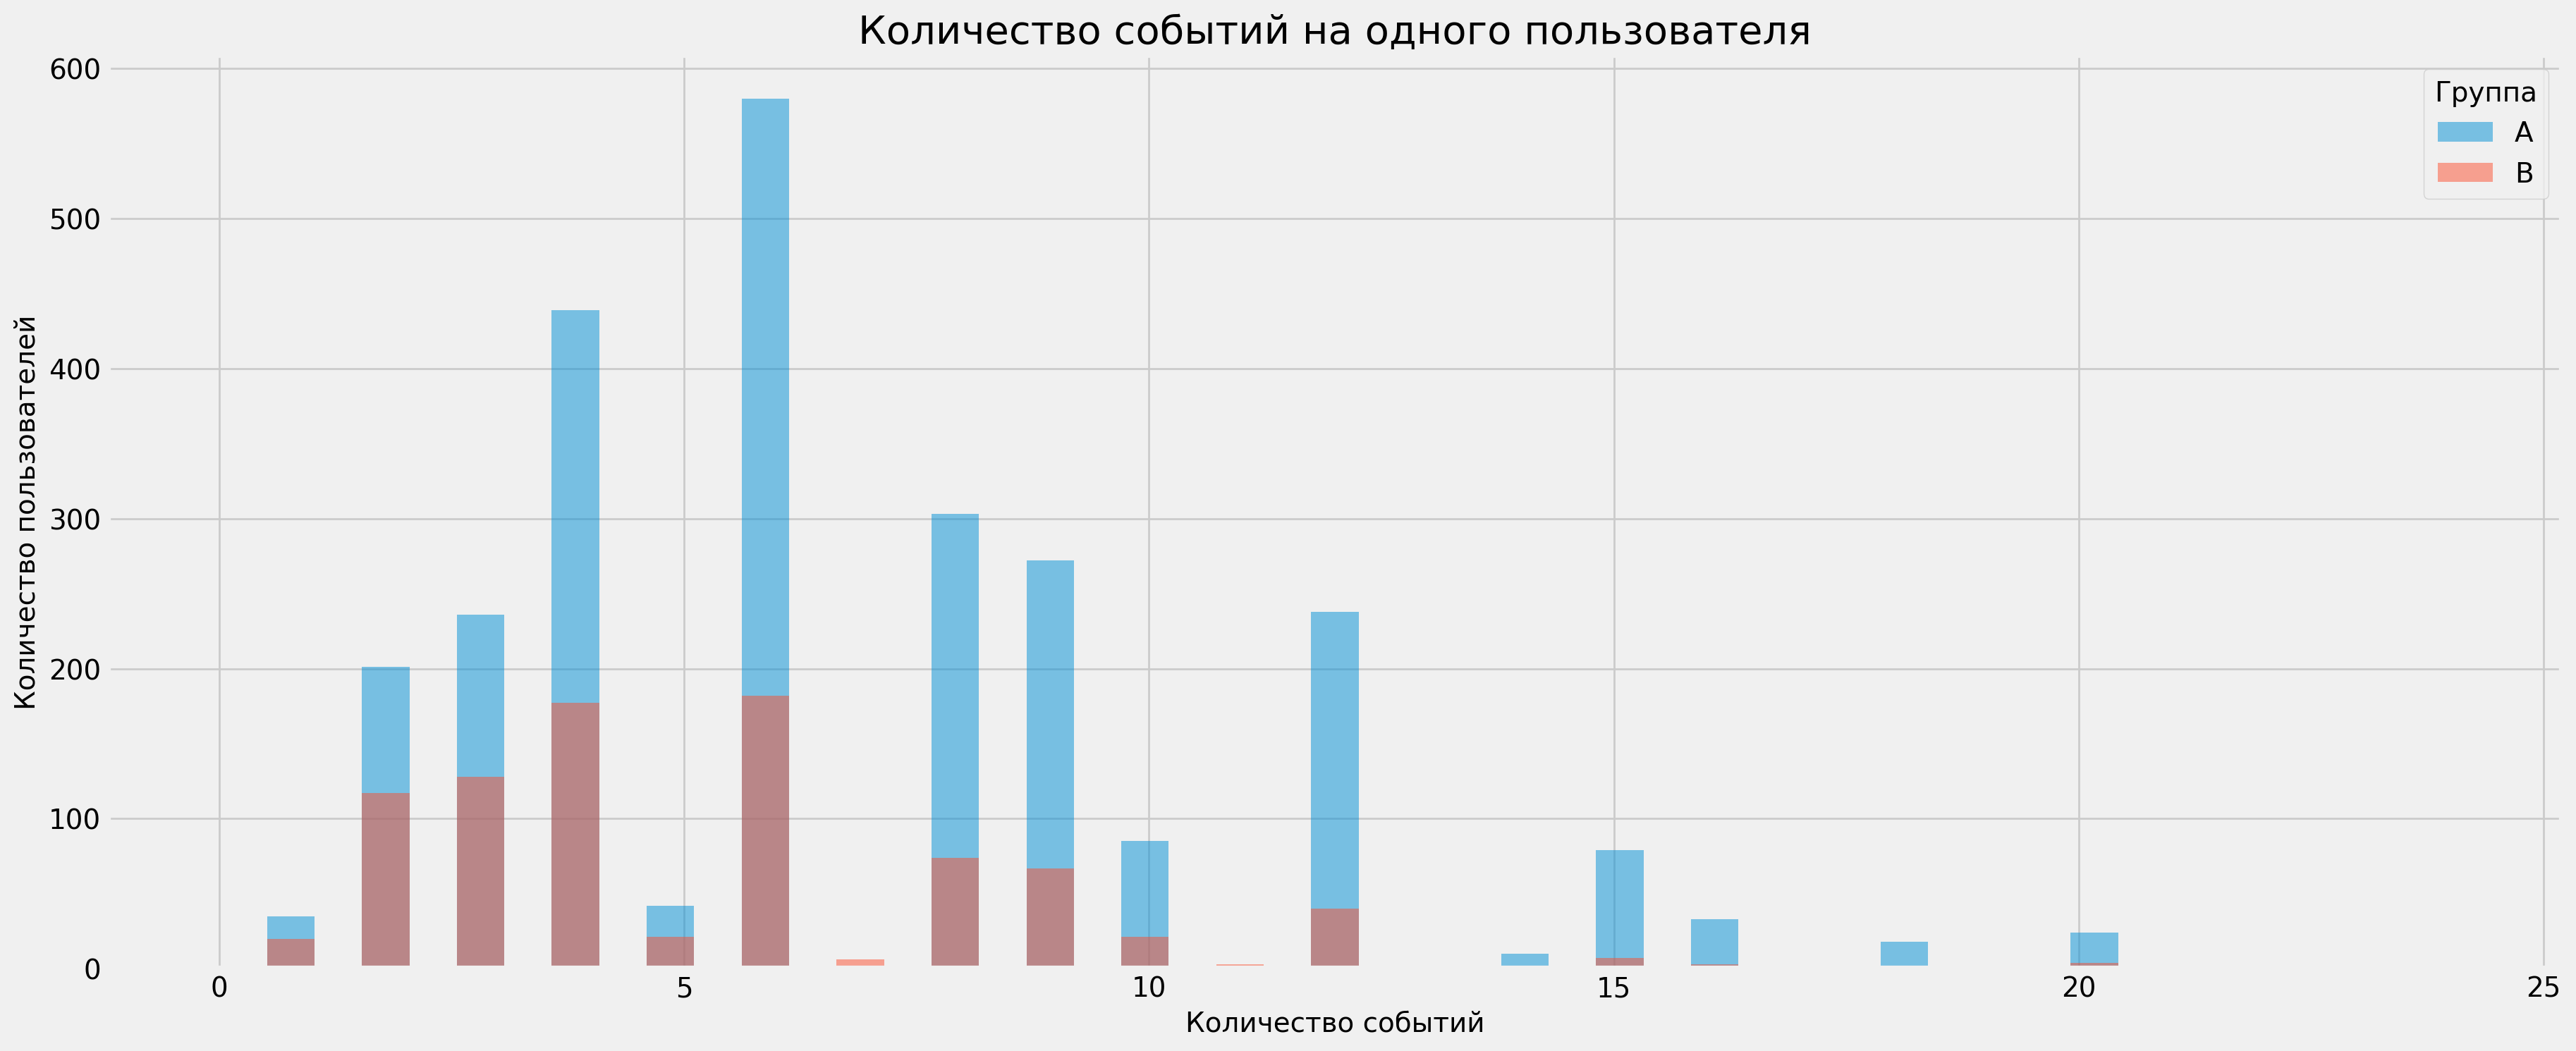

In [48]:
bins = np.linspace(0, data_AB.query('group =="A"')['total'].max(), 
                   data_AB.query('group =="A"')['total'].max()*2)
plt.hist(data_AB.query('group =="A"')['total'], bins, alpha=0.5, label="A")
plt.hist(data_AB.query('group =="B"')['total'], bins, alpha=0.5, label="B")
plt.legend(title='Группа')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.title('Количество событий на одного пользователя')
plt.show();

В обеих группах чаще всего на пользователя приходится 6 событий. При этом можно отметить малую частоты 1, 5 и 7 событий для обеих групп, хотя остальное количество событий от 1 до 10 встречается гораздо чаще.

In [49]:
print('Количество событий, группа А:', data_AB.query('group == "A"')['total'].sum())
print('Количество пользователей, группа А:', data_AB.query('group == "A"')['user_id'].count())
print('Количество событий в среднем на одного пользователя, группа А:', 
      '{0:.1f}'.format(data_AB.query('group == "A"')['total'].mean()))

Количество событий, группа А: 17977
Количество пользователей, группа А: 2604
Количество событий в среднем на одного пользователя, группа А: 6.9


In [50]:
print('Количество событий, группа B:', data_AB.query('group == "B"')['total'].sum())
print('Количество пользователей, группа B:', data_AB.query('group == "B"')['user_id'].count())
print('Количество событий в среднем на одного пользователя, группа B:', 
      '{0:.1f}'.format(data_AB.query('group == "B"')['total'].mean()))

Количество событий, группа B: 4850
Количество пользователей, группа B: 876
Количество событий в среднем на одного пользователя, группа B: 5.5


В группе А почти в 3 раза больше событий, чем в группе В, а пользователей - больше, чем в 2 раза. При этом в среднем на одного пользователя из группы А приходится почти 7 событий, а на пользователя из группы В - 5.5 событий.

### Динамика событий

Посмотрим на изменение количество событий по дням для каждой группы.

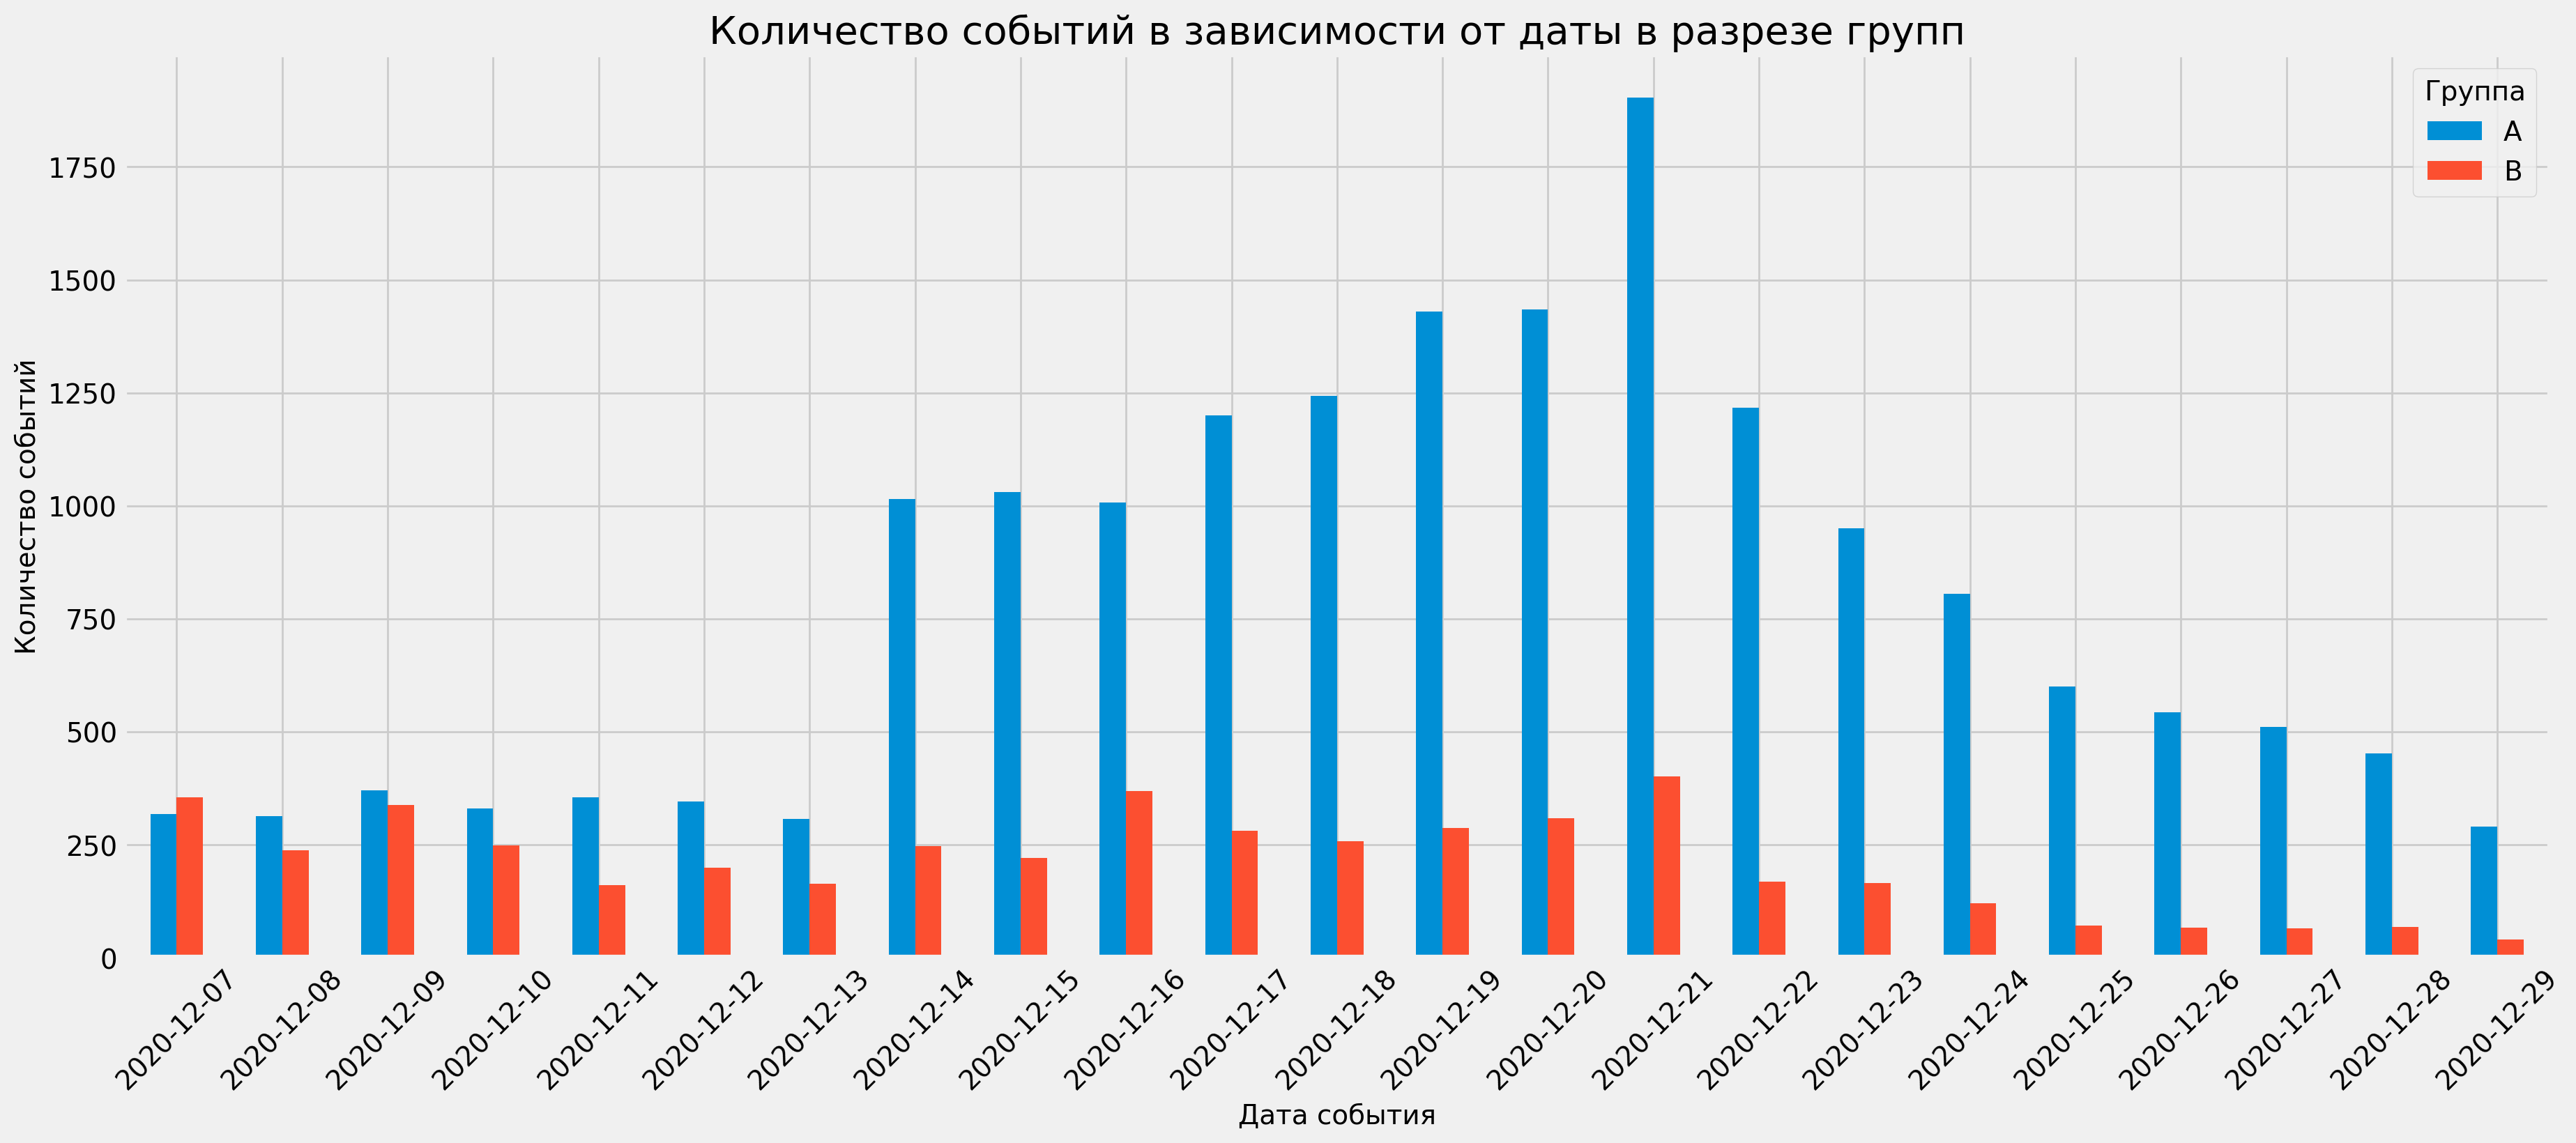

In [51]:
fig = plot_bar(life_events_r, 'date', 'event_name', 'count')
plt.legend(title='Группа')
plt.xlabel('Дата события')
plt.ylabel('Количество событий')
plt.title('Количество событий в зависимости от даты в разрезе групп')
plt.xticks(rotation=45)
plt.show();

После даты регистрации пользователи активно совершали события (с первого же дня для обеих групп количество событий выше 200 за день). К 13 декабря у группы В количество событий упало ниже 200, немного возросло к 16 декабря, но после 21 декабря начало стремительно уменьшаться. При этом для группы А 14 декабря произошло внезапно увеличение количество событий выше 1000 событий за день, продержалось 3 дня на одном уровне и начало расти до конца второй недели теста. Пиковое значение для группы А пришлось на 21 декабря, а далее начало убывать до конца исследуемого периода. Для группы В таких всплесков не наблюдалось. Для каждого дня, кроме самого первого, количество событий для группы А было выше количества событий для группы В.

Что могло оказать на активность пользователей из группы А не ясно. Динамика набора пользователей в группу А и В была одинаково циклична каждую неделю и имела схожий характер (разница была только в количестве самих пользователей). При этом, для группы В нет такого изменения по количеству событий от даты события. Такой всплеск наблюдается только для группы А. 

Посмотрим на приток новых пользователей по группам по датам.

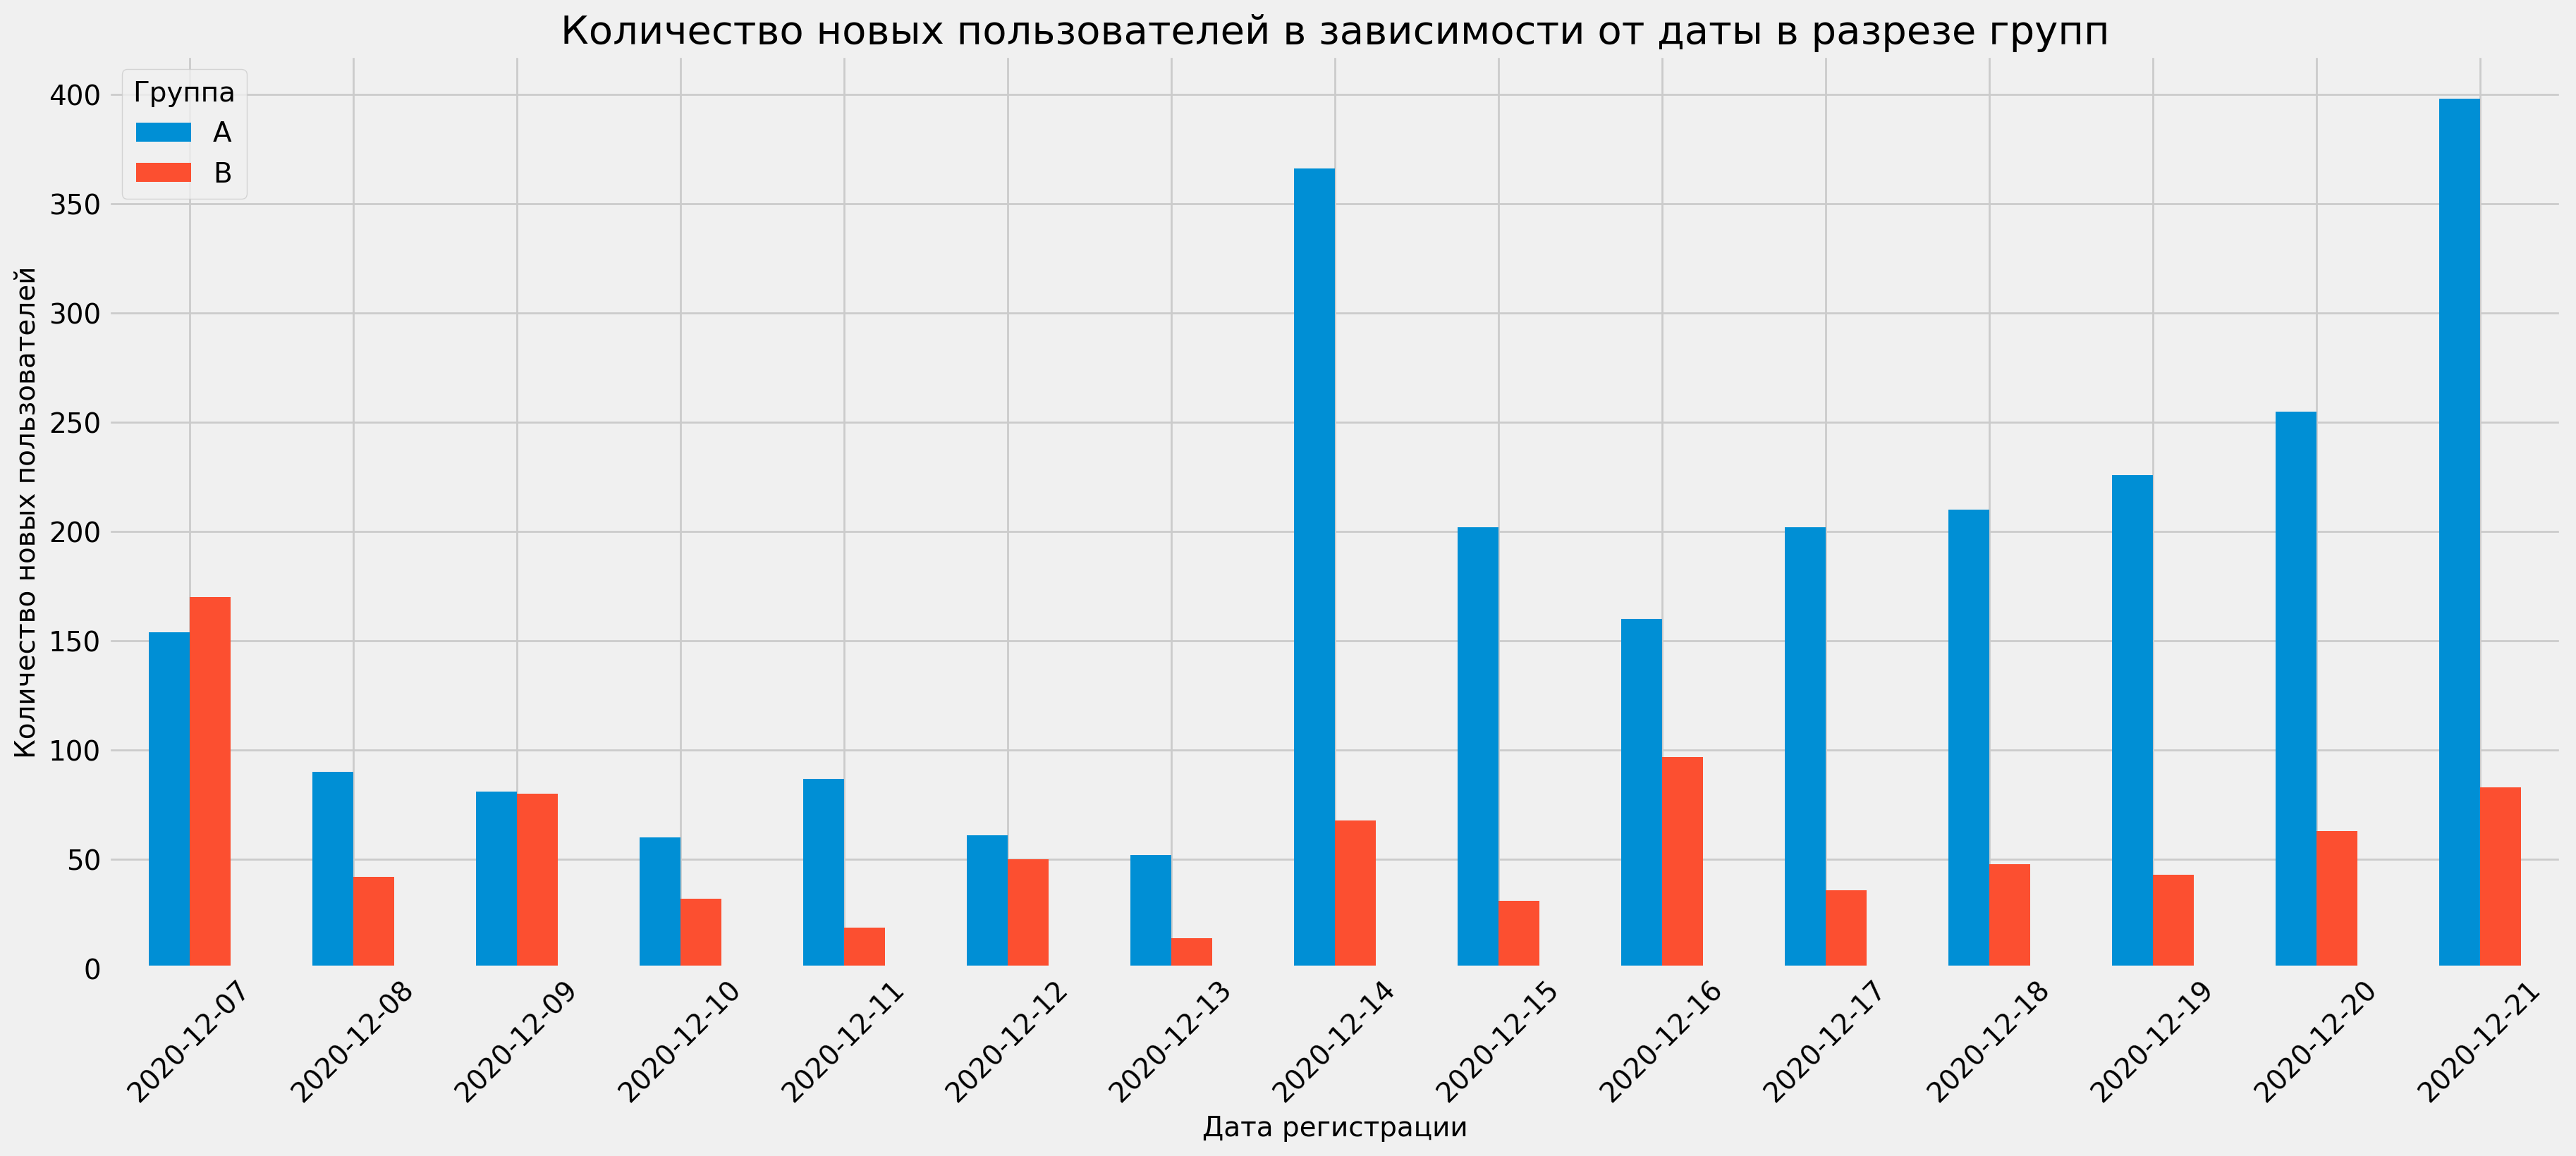

In [52]:
fig = plot_bar(life_events_r, 'first_date', 'user_id', 'nunique')
plt.legend(title='Группа')
plt.xlabel('Дата регистрации')
plt.ylabel('Количество новых пользователей')
plt.title('Количество новых пользователей в зависимости от даты в разрезе групп')
plt.xticks(rotation=45)
plt.show();

В группе А 14 декабря резко возрос приход новых пользователей. Для группы В такого не наблюдалось, приток новых пользователей остался примерно прежним. Так что этим можно объяснить резко возросшее количество событий с 14 декабря для пользователей группы А. Но при этом, что спровоцировало приток новых пользователей в группу А 14 декабря, не ясно.

### Маркетинговые активности

Посмотрим на график запланированных маркетинговых активностей и нет ли пересечения с тестовым периодом.

In [53]:
region = 'EU'
min_date = life_events['event_dt'].min()
max_date = life_events['event_dt'].max()
mark_events[(mark_events['regions'].str.contains(region)) & \
            (((mark_events['start_dt'] >= min_date) & (mark_events['start_dt'] <= max_date)) | \
            ((mark_events['finish_dt'] >= min_date) & (mark_events['finish_dt'] <= max_date)))]

name        regions   start_dt  finish_dt
0  Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03

С исследуемым тестом пересекается только 1 промо компания - Новогодняя. Она проводилась в целевом регионе - Европе, и дата её старта совпадает с промежутком времени теста. Маркетинговая компания была запущена 25 декабря. Из графика динамики количества событий от даты с этого периода и до конца теста не было видно никаких изменений - количество событий для пользователей для обеих групп уменьшалось. 

### Продуктовая воронка

Посмотрим на частоту событий для каждой из групп.

Построим продуктовую воронку для каждой из групп согласно такому порядку событий:
- `login` - авторизация в приложении
- `product_page` - страница продукта
- `product_cart` - корзина
- `purchase` - покупка продукта

In [54]:
# Порядок продуктовой воронки
new_index = ['login', 'product_page', 'product_cart', 'purchase']

In [55]:
event_pivot(life_events_r.query('group == "A"'), 'event_name', 'count')\
           .style.format({'part': '{:.1%}'})\
           .background_gradient(cmap_table)

In [56]:
event_pivot(life_events_r.query('group == "B"'), 'event_name', 'count')\
           .style.format({'part': '{:.1%}'})\
           .background_gradient(cmap_table)

Для группы В на событие авторизации приходится 48% от всех событий, а для группы А - 44%. При этом все остальные события для группы В происходят на пару пунктов реже, чем для группы А. Также можно отметить, что частота событий у группы В для корзины и оплаты покупки одинаковая, а вот у группы А оплата происходит чаще, чем просмотр корзины на 0.6 процентных пунктов.

Посчитаем, сколько пользователей совершали то или иное событие для разных групп:

In [57]:
event_pivot(life_events_r.query('group == "A"'), 'user_id', 'nunique')\
           .style.format({'part': '{:.1%}'})\
           .background_gradient(cmap_table)

In [58]:
event_pivot(life_events_r.query('group == "B"'), 'user_id', 'nunique')\
           .style.format({'part': '{:.1%}'})\
           .background_gradient(cmap_table)

Можно отметить, что для группы А пользователь совершает покупку без посещения корзины на 0.9 процентных пункта чаще, а для пользователя группы В - на 0.5 процентных пункта чаще.

In [59]:
product_A = event_step(life_events_r.query('group == "A"'))
product_A.style.format({'ret_rate': '{:.1%}'})\
          .background_gradient(cmap_table)

In [60]:
product_B = event_step(life_events_r.query('group == "B"'))
product_B.style.format({'ret_rate': '{:.1%}'})\
          .background_gradient(cmap_table)

Для группы А после авторизации на второй шаг переходит 65% пользователей, а для группы В только 56%. Для обеих групп пользователи иногда пропускают пункт с корзиной и переходят сразу в оплату. Поэтому в оплату для группы А конвертируется 107% по отношению к предыдущему пункту, а у группы В - 102%.

Посмотрим, какая доля пользователей доходит от авторизации до оплаты заказа:

In [61]:
print('Доля пользователей для группы А, которая дошла от авторизации до оплаты заказа:',
      "{0:.1%}".format(product_A.loc[3, 'total'] / product_A.loc[0, 'total']))
print('Доля пользователей для группы В, которая дошла от авторизации до оплаты заказа:',
      "{0:.1%}".format(product_B.loc[3, 'total'] / product_B.loc[0, 'total']))

Доля пользователей для группы А, которая дошла от авторизации до оплаты заказа: 32.0%
Доля пользователей для группы В, которая дошла от авторизации до оплаты заказа: 28.3%


Можно отметить, что у группы А больше пользователей переходят от авторизации к оплате заказа: на 3.6 процентных пункта больше, чем для группы В. При этом, у группы В процент таких пользователей ниже 30%.

Построим визуализацию воронки событий для группы А и группы В:

In [62]:
fig = go.Figure()
fig.add_trace(go.Funnel(name = 'Группа А',
                        y = product_A['event_name'],
                        x = product_A['total'],
                        textposition = "inside",
                        textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(name = 'Группа В',
                        y = product_B['event_name'],
                        x = product_B['total'],
                        textposition = "inside",
                        textinfo = "value+percent initial"))
fig.show()

Из графика визуализации воронки событий наглядно видно, что больше всего потеря пользователей для группы А происходит на втором и третьем шаге - перехода от авторизации в корзину и оплаты заказа. Только 65% и 30%, соответственно, после авторизации доходят до этого пункта. 

Для группы В, по сравнению с тестовой группой А, можно отметить бо\'льшую потерю доли пользователей на втором шаге воронки - показа страниц товара. Также только 28% пользователей доходит до покупки товара после авторизации.

### Промежуточные выводы:

- В группе А почти в 3 раза больше событий, чем в группе В, а пользователей - больше, чем в 2 раза. 
- В среднем на одного пользователя из группы А приходится 7 событий, а на пользователя из группы В - 6 событий.
- После даты регистрации пользователи активно совершали события для обеих тестовых групп.
- Для каждого дня, кроме самого первого, количество событий для группы А было выше количества событий для группы В.
- Для группы А 14 декабря произошло внезапно увеличение количество событий выше 1000 событий за день, на 21 декабря пришёлся пик, а затем начало убывать до конца исследуемого периода.
- Для группы В количество событий после 21 декабря до конца тестового периода уменьшается.
- С исследуемым тестом пересекается только 1 промо компания - Новогодняя. Она проводилась в целевом регионе - Европе, и дата её старта (25 декабря) совпадает с промежутком времени теста. 
- По графику динамики количество событий от тестового дня не было видно влияния промо компании, количество событий для пользователей для обеих групп уменьшалось.
- Порядок событий в продуктовой воронке для каждой из групп:
    - `login` - авторизация в приложении
    - `product_page` - страница продукта
    - `product_cart` - корзина
    - `purchase` - покупка продукта
- Для группы В на событие авторизации приходится 48% от всех событий, а для группы А - 44%. 
- На 0.5 процентных пунктов пользователь из группы В чаще совершал сразу покупку без посещения корзины, а для группы А - на 0.9 процентных пункта.
- Для группы А после авторизации на второй шаг переходит 65% пользователей, а для группы В только 56%. 
- В корзину с предыдущего шага для группы А переходит 46%, а для группы В - 50% пользователей. 
- В оплату для группы А конвертируется 106%, а у группы В - 102%.
- У группы А больше пользователей переходят от авторизации к оплате заказа: на 3.6 процентных пунктов больше, чем для группы В. 
- Для обеих групп этот процент перехода пользователей от авторизации к оплате заказа ниже 35%.
- Большая потеря пользователей для обеих групп происходит на втором шаге воронки - показа страниц товара, причём для группы В на 9 процентных пунктов меньше пользователей после авторизации доходят до этого пункта, чем для группы А.

В целом, не было зафиксировано более успешного поведения пользователей из группы В по отношению к пользователям из группы А.

## Оценка результатов А/В тестирования

Вспомним, сколько пользователей находится в каждой группе:

In [63]:
result_group = table_pivot(life_events_r, 'group', 'user_id', 'nunique')
result_group['part_user'] = result_group['total'] / (life_events_r['user_id'].nunique())
result_group.style.format({'part_user': '{:.1%}'})\
            .background_gradient(cmap_table)

Разница между количеством пользователей в разных группах почти в 3 раза.

Соберём отдельно выборки по каждой из групп для каждого события.

In [64]:
# Выборка с количеством пользователей группы А для каждого события
sampleA = life_events_r.query('group == "A"')\
                       .groupby(by=['event_name'])\
                       .agg(total_A = ('user_id', 'nunique'))\
                       .reindex(new_index)\
                       .reset_index() 
# Выборка с количеством пользователей группы B для каждого события
sampleB = life_events_r.query('group == "B"')\
                       .groupby(by=['event_name'])\
                       .agg(total_B = ('user_id', 'nunique'))\
                       .reindex(new_index)\
                       .reset_index()
# Соединение групп в один датасет
successes = pd.merge(sampleA, sampleB, how ='inner', on ='event_name')
successes

event_name  total_A  total_B
0         login     2604      876
1  product_page     1685      493
2  product_cart      782      244
3      purchase      833      248

Посчитаем статистическую значимость различий между тестовыми группами.

<p>Введём нулевую и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Статистически значимых различий в количестве пользователей для каждого события двух групп нет.}\\
   H_1 :\text{Статистически значимые различия для каждого события между группами есть.}
 \end{cases}
\end{equation*}$

Проверка выборок z-тестом. Уровнем начальной статистической значимости считается значение 0.05. Так как мы проверяем выборки попарно, то необходимо скорректировать уровень стат значимости, чтобы избежать возникновения ошибки первого рода – ложного отклонения нулевой гипотезы. Применим метод Шидака, для которого обеспечивается, что групповая вероятность ошибки первого рода будет меньше уровня стат значимости.

In [65]:
# Задаём уровень значимости
alpha = 0.05
# Задаём уровень значимости с условием поправки
alpha = 1 - (1 - alpha)**(1/4)

In [66]:
name_event = new_index[1:len(new_index)]
for i in name_event:
    n_event = successes.index[successes['event_name'] == i].to_list()[0]
    test_hipot(n_event)

Событие:  product_page
Доля пользователей, прошедших на этот этап, в группе А:  64.7%
Доля пользователей, прошедших на этот этап, в группе B:  56.3%
p-значение:  8.2e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница

Событие:  product_cart
Доля пользователей, прошедших на этот этап, в группе А:  30.0%
Доля пользователей, прошедших на этот этап, в группе B:  27.9%
p-значение:  0.222
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие:  purchase
Доля пользователей, прошедших на этот этап, в группе А:  32.0%
Доля пользователей, прошедших на этот этап, в группе B:  28.3%
p-значение:  0.0418
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



По результатам z-теста получилось отличие для групп А и В только для второго шага воронки: переход на страницу товаров. Только для этого этапа воронки есть статистически значимое различие между группами. Разница между долями составляет 8.4 процентных пункта, причём не в пользу тестовой группы В. Для остальных этапов воронки требование о повышение конверсии покупателей на 5 процентных пунктов выполнено не было, так как у группы В показатели хуже по сравнению с группой А. Так как у нас было зафиксировано статистическое различие только в 1 проверке из трёх, то гипотезу о статистически значимых различий между долями для разных тестовых групп принимать нельзя. 

### Промежуточные выводы:

Была проведена проверка статистически значимого различия между конверсии покупателей на каждом шаге воронки для разных тестовых групп. 
- Статистически значимое различие было только для второго шага воронки - для тестовой группы В конверсия покупателей упала на 5.8 процентных пункта по отношению к тестовой группе А. 
- Для остальных шагов статистически значимых различий по долям не было. 
- Группа В не показала результаты лучше, чем группа А для всех пунктов воронки. 
- Гипотезу о статистически значимых различиях между долями для каждого шага воронки для разных тестовых групп на основании проведённого статистического теста отвергаем, так как различие было только на одном шаге из трёх, причём не в пользу группы В.

## Итоги исследования

Было проведено исследовани A/B-теста для приложение с продажей товаров.

Перед анализом, данные были подготовлены для корректной работы:
- Было загружено 4 датасета с информацией о проведённом A/B тесте.
- Ни в одной таблице не было явных дубликатов.
- В таблице с событиями пользователей в 1 столбце было 86% пропусков данных.
- Пропуски в данных могли возникнуть из-за отсутствия дополнительной информации о событиях.
- Столбцы с датами были приведены к правильному типу данных.
- Неявных дубликатов обнаружено не было.

Была проведена корректность данных А/В тестирования:
- Период набора пользователей согласуется с заявленными в ТЗ датах.
- Участники необходимого теста, составляют 15% от общего числа пользователей из Европы, зарегистрированных в период набора пользователей в тест.
- Были оставлены только участники целевого региона - Европы.
- Было проведено 2 разных теста, был оставлен только один рассматриваемый - recommender_system_test.
- Во все дни в группы А и В попадало разное количество пользователей, причём в группу А больше. 
- Самое большое различие по процентному соотношению между группами приходится на 16 декабря и составляет 32%.
- Самое маленькое различие по процентному соотношению между группами приходится на 10 декабря и составляет 3.5%. 
- Во второй половине теста с 15 по 21 декабря была тенденция к увеличению числа участников каждой группы. 
- 1602 пользователей находятся одновременно в конкурирующих тестах и это составляет почти 10% от всех данных.
- Было решено оставить таких пользователей, так как изучается влияние лишь одного теста на поведение пользователей, без сравнения одного теста с другим.
- Между тестовыми группами А и В нет пересечений пользователей.
- События для пользователей, которые участвуют в тестировании, предоставлены с 7 декабря по 30 декабря, а не по 4 января.
- Были оставлены только те пользователи, которые были зарегистрированы до 16.12.2020 включительно, чтобы соблюдался лайфтайм 14 дней от регистрации.
- Уникальных событий всего 4 штуки. По логике событий они распологаются в таком порядке:
    - `login` - авторизация в приложении
    - `product_page` - страница продукта
    - `product_cart` - корзина
    - `purchase` - покупка продукта
- Большая часть событий приходится на авторизацию пользователя, а на оплату покупки и просмотра корзины приходится по 13%.
- Были оставлены только те события, которые происходили до 14 дней после регистрации пользователя.
- Все события пользователи совершают в первый день регистрации.
- Авторизацию пользователи совершают в первые 12 часов после регистрации, а все остальные пункты воронки пользователи проходят на 13-й час после регистрации. 
- Оплата происходит в среднем на 18 минут позже, чем посещение страницы с товарами, и на 23 минуты позже, чем авторизация.
- После удаления ненужных событий было обнаружено, что 1 пользователь пропустил этап авторизации.

Некоторые пункты проведения чистого АВ анализа нарушены. Это сказалось на результатах тестирования: 
- Есть пересечения между конкурирующими тестами.
- В группе А и В всё время набиралось разное количество пользователей.
- Относительное различие пользователей в группах больше, чем в 2 раза.
- Не все пользователи были из целевой области.
- 1 пользователь пропустил первый этап воронки - авторизацию. 

Был проведён исследовательский анализ для тестовых групп:
- В группе А почти в 3 раза больше событий, чем в группе В, а пользователей - больше, чем в 2 раза. 
- В среднем на одного пользователя из группы А приходится 7 событий, а на пользователя из группы В - 6 событий.
- После даты регистрации пользователи активно совершали события для обеих тестовых групп.
- Для каждого дня, кроме самого первого, количество событий для группы А было выше количества событий для группы В.
- Для группы А 14 декабря произошло внезапно увеличение количество событий выше 1000 событий за день, продержалось 3 дня и начало убывать до конца исследуемого периода.
- Для группы В количество событий после 21 декабря до конца тестового периода уменьшается.
- С исследуемым тестом пересекается только 1 промо компания - Новогодняя. Она проводилась в целевом регионе - Европе, и дата её старта (25 декабря) совпадает с промежутком времени теста. 
- По графику динамики количество событий от тестового дня не было видно влияния промо компании, количество событий для пользователей для обеих групп уменьшалось.
- Порядок событий в продуктовой воронке для каждой из групп:
    - `login` - авторизация в приложении
    - `product_page` - страница продукта
    - `product_cart` - корзина
    - `purchase` - покупка продукта
- Для группы В на событие авторизации приходится 48% от всех событий, а для группы А - 45%. 
- На 0.3% пользователь из группы В чаще совершал сразу покупку без посещения корзины.
- Для группы А после авторизации на второй шаг переходит 63% пользователей, а для группы В только 57%. 
- В корзину с предыдущего шага для группы А переходит 48%, а для группы В пользователи сразу переходят на страницу оплаты 50% пользователей. 
- В оплату для группы А конвертируется 99%, а у группы В после оплаты в корзину заходят 98%.
- У группы А больше пользователей переходят от авторизации к оплате заказа: на 1.6 процентных пунктов больше, чем для группы В. 
- Для обеих групп этот процент перехода пользователей от авторизации к оплате заказа ниже 30%.
- Большая потеря пользователей для обеих групп происходит на втором шаге воронки - показа страниц товара, причём для группы В на 6 процентных пунктов меньше пользователей после авторизации доходят до этого пункта, чем для группы А.

В целом, не было зафиксировано более успешного поведения пользователей из группы В по отношению к пользователям из группы А.

Была проведена проверка статистически значимого различия между конверсии покупателей на каждом шаге воронки для разных тестовых групп:
- Статистически значимое различие было только для второго шага воронки - для тестовой группы В конверсия покупателей упала на 5.8 процентных пункта по отношению к тестовой группе А.  
- Для остальных шагов статистически значимых различий по долям не было. 
- Группа В не показала результаты лучше, чем группа А для всех пунктов воронки. 
- Между группами было различие на втором шаге воронки.
- Гипотезу о статистически значимых различиях между долями для каждого шага воронки для разных тестовых групп на основании проведённого статистического теста не принимаем. 


**Можно подвести общий итог:** 
- Корректность проведения тестирования была нарушена, в группы из исследуемого теста попала часть пользователей из другого теста
- В группу А каждый день попадало больше пользователей, чем в группу В
- Присутствовала недельная цикличность в наборе пользователей. 
- В группе А без видимых на то причин резко возросло количество событий и держалось до конца тестирования, хотя макретинговые акции не пересекались с проведением тестированния в этот момент. 
- Проверка статистически значимых различий для групп показала, что для второго шага продуктовой воронки доли пользователей отличаются не в пользу группы В, но статистически значимое различие было только для одного шага из трёх. 
- Гипотезу о статистически значимой разницы между долями тестовых групп принимать нельзя, в двух из трёх шагов продуктовой воронки статистически значимой разницы не было. 

При этом выборки для группы В оказалось недостаточно. По калькулятору видно, что для изменения конверсии в 5 процентов необходима выборка в 1550 пользователя при нынешнем проценте конверсии группы В на втором шаге. А у нас на данный момент было 876. Так как продление тестирования, чтобы получить однозрачный результат, дорого и вряд ли даст положительный результат, то  лучше склониться к версии того, чтобы завершить тестирование с признанием неуспеха проведённого изменения. 

Тест recommender_system_test не показал действенного результата на поведение пользователей в приложении.

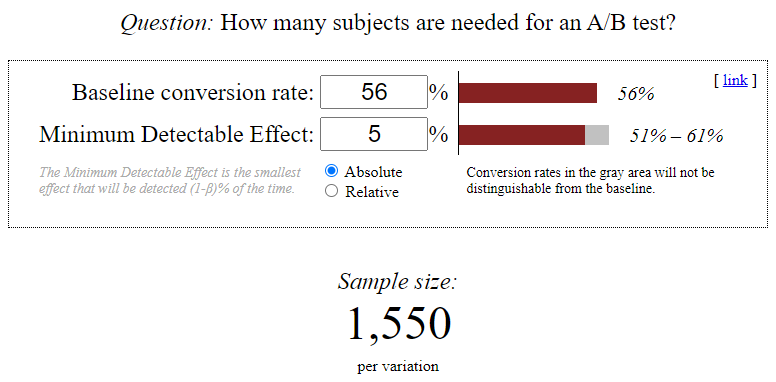